<a href="https://colab.research.google.com/github/Ashupathak2001/Machine_learning/blob/main/Training_neural_network_onGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Training Deep neural network on GPU**

In [ ]:
# importing libraries
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
# Prepare data
# download data
dataset=MNIST(root="data/",train=True,transform=ToTensor(),download=True)
test_ds=MNIST(root="data/",train=True,transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 143046858.85it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41399758.65it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38880844.85it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20865858.45it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



image shape=[1, 28, 28]
label=5


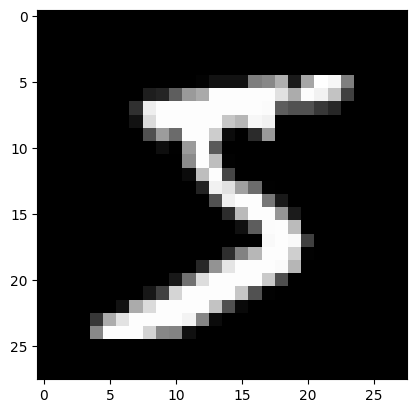

In [ ]:
# explore data
img,labels=dataset[0]
print("image shape=%s" % list(img.shape))
print("label=%s" % labels)
plt.imshow(img[0], cmap="gray");

In [ ]:
print("dataset size=%s" % len(dataset))
print("testset size=%s" % len(test_ds))

dataset size=60000
testset size=60000


In [ ]:
# split dataset to training & validation sets
val_size=15000
train_size=len(dataset)-val_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])

In [ ]:
# create data loaders
batch_size=128
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)
test_loader=DataLoader(test_ds,batch_size*2,num_workers=4,pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# define neural network
class MnistModel(nn.Module):
  def __init__ (self,in_features:int, hidden_size:int, out_classes:int):
      super().__init__()
      self.linear1=nn.Linear(in_features, hidden_size)
      self.linear2=nn.Linear(hidden_size, out_classes)

  def forward(self,X:torch.tensor)->torch.tensor:
    # flatten images
    X=X.reshape(-1,self.linear1.in_features)
    # compute activation units
    Z=self.linear1(X)
    A=F.relu(Z)
    # compute probabilities
    Y_linear=self.linear2(A)
    return Y_linear

  def predict(self,X:torch.tensor)->torch.tensor:
    Y_linear=self(X)
    probs=F.softmax(Y_linear.detach(),dim=1)
    _, Y_hat=torch.max(probs, dim=1)
    return Y_hat

  def cost_func(self,batch:list)->torch.tensor:
    images,labels=batch
    Y_linear=self(images)
    cost=F.cross_entropy(Y_linear, labels)
    return cost

  def evaluate(self,batch:list)-> dict:
    images, labels = batch
    Y_hat = self.predict(images)
    acc = torch.sum(Y_hat == labels).item()/len(Y_hat)
    Y_linear = self(images)
    cost = F.cross_entropy(Y_linear.detach(), labels).item()
    res = {
        "cost": cost,
        "accuracy": acc
    }
    return res

In [ ]:
input_features=1*28*28
hidden_size=32
output_classes=10

In [ ]:
model=MnistModel(input_features,hidden_size,output_classes)

In [ ]:
# Using GPU
def getDefaultDevice():
    """Pick GPU if available, else CPU
    """
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

In [ ]:
def toDevice(data,device:torch.device):
  if isinstance(data,(list,tuple)):
    return [toDevice(x,device) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
  def __init__(self,dataloader:DataLoader,device:torch.device):
    #this class is to wrap data loader and move batches of data to selected device
    self.dataloader=dataloader
    self.device=device

  def __iter__(self):
    # this method is to retrieve batches of data
    for batch in self.dataloader:
      yield toDevice(batch, self.device)

  def __len__(self):
    # this method is to get the number of batches
    return len(self.dataloader)

In [ ]:
device=getDefaultDevice()
toDevice(model, device)
train_loader=DeviceDataLoader(train_loader, device)
val_loader=DeviceDataLoader(val_loader, device)
print("device used : %s" % device.type)

device used : cuda


In [ ]:
# Train Model
def evaluateEpoch(batch_evals: list, decimals=2)-> dict:
  """Get cost & accuracy of predictions of an epoch

    Args:
        batch_evals (list): list of batch evaluations
        decimals (int, optional): decimals to round values

    Returns:
        dict: containing 2 keys "cost" & "accuracy"
    """
  batch_costs=[x["cost"] for x in batch_evals]
  batch_accs=[x["accuracy"] for x in batch_evals]
  cost= sum(batch_costs)/len(batch_costs)
  acc=sum(batch_accs)/len(batch_accs)
  res={
      "cost":round(cost, decimals),
      "accuracy":round(acc, decimals)
  }
  return res

In [ ]:
def fit(epochs:int,model:MnistModel,optimizer:torch.optim,train_loader:DataLoader,val_loader:DataLoader)->list:
  """Train model

    Args:
        epochs (int): number of iterations
        model (MnistModel): model to train
        optimizer (torch.optim): function to optimize model parameters
        train_loader (DataLoader): data loader for training phase
        val_loader (DataLoader): data loader for validation phase

    Returns:
        list: evaluation results of epochs
    """
  logs=list()
  for i in range(epochs):
    # training phase
    for batch in train_loader:
      cost=model.cost_func(batch)
      cost.backward()
      optimizer.step()
      optimizer.zero_grad()

    # validation phase
    batch_evals=[model.evaluate(batch) for batch in val_loader]
    res = evaluateEpoch(batch_evals)
    logs.append(res)
    print("epoch %s: validation cost = %s, validation accuracy = %s" %
          (i+1, res["cost"], res["accuracy"]))
  return logs

In [ ]:
epochs=10
lr=1e-1
optimizer=torch.optim.SGD(model.parameters(),lr)
logs=fit(epochs,model,optimizer,train_loader,val_loader)

epoch 1: validation cost = 0.35, validation accuracy = 0.9
epoch 2: validation cost = 0.29, validation accuracy = 0.92
epoch 3: validation cost = 0.26, validation accuracy = 0.93
epoch 4: validation cost = 0.24, validation accuracy = 0.93
epoch 5: validation cost = 0.22, validation accuracy = 0.94
epoch 6: validation cost = 0.2, validation accuracy = 0.94
epoch 7: validation cost = 0.18, validation accuracy = 0.95
epoch 8: validation cost = 0.18, validation accuracy = 0.95
epoch 9: validation cost = 0.17, validation accuracy = 0.95
epoch 10: validation cost = 0.17, validation accuracy = 0.95


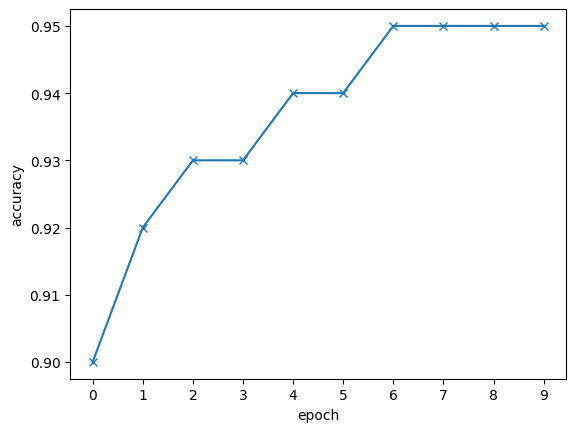

In [ ]:
# evaluation on validation set
accuracies = [log['accuracy'] for log in logs]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xticks(range(epochs))
plt.show();

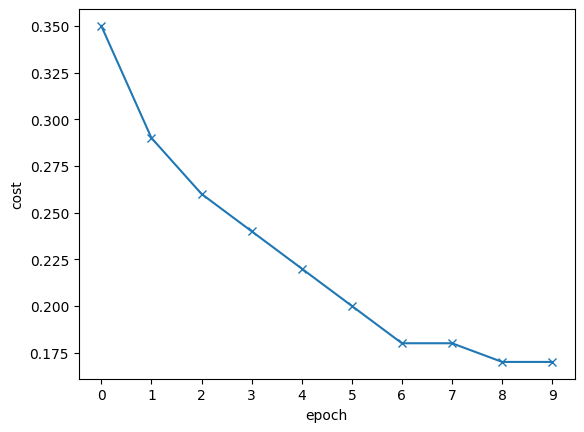

In [ ]:
costs = [log['cost'] for log in logs]
plt.plot(costs, '-x')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.xticks(range(epochs))
plt.show();

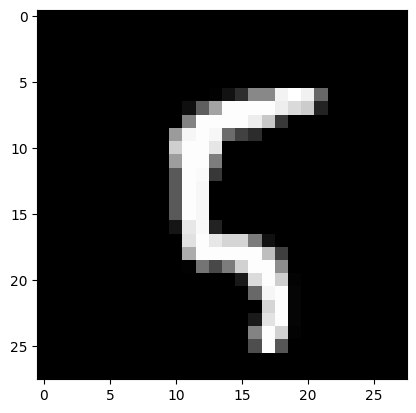

In [ ]:
# predict on test set
img, labels =test_ds[100]
plt.imshow(img[0],cmap="gray")

In [ ]:
print("img.device = %s" % img.device)
img = toDevice(img, device)
print("img.device = %s" % img.device)
y_hat = model.predict(img)
print('Label: {}, Predicted: {}'.format(labels, y_hat.item()))

img.device = cpu
img.device = cuda:0
Label: 5, Predicted: 5


In [ ]:
# Evaluation on test set
test_loader = DeviceDataLoader(test_loader, device)
batch_evals = [model.evaluate(batch) for batch in test_loader]
res = evaluateEpoch(batch_evals)
print('test cost = {}, test accuracy = {}'.format(res['cost'], res['accuracy']))

test cost = 0.16, test accuracy = 0.95
